# Final Version (Acc-Stop & Acc-Go)

### External Modules

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import newton
from ADRpy import atmospheres as at

In [39]:
plt.rcParams["figure.figsize"]=15,10 #Set plot size
plt.rcParams.update({'font.size': 16}) #set plot size font
plt.rcParams.update({"axes.grid" : True, "grid.color": "lightgrey"}) #Add grid lines to plot

### Conversions

In [40]:
def Knots(MS):
    return MS / 0.5144

def MS(Knots):
    return Knots * 0.5144

def radian(degree):
    return degree * np.pi/180

def Feet2M(feet):
    return feet / 3.281

### Environment Parameters

In [169]:
g = 9.81        #Gravitational Constant
rho = 1.225

# Wind Speed / Direcion
#     Headwind +ve
#     Cross wind +ve from right
w_vel = 0
w_deg = 0

mu = 0.05    #Driction Coefficient to Runway Surface

temp_c = 15     #Airfield OAT temperacture in celcius
alt_ft = 83     #Airfield (runway) altitude in feet
RunwayLength = 2500

In [170]:
# Vw = MS(5) #5 kt headwind
Vw = 5

#### Calculate $\rho$ at Airfield Temp and Altitude

In [171]:
def sealevel(t):
    isa_offset = at.Atmosphere(offset_deg=t)
    return isa_offset.airtemp_c(Feet2M(alt_ft)) - temp_c

In [172]:
isa_offset = at.Atmosphere(offset_deg=newton(sealevel,0))
rho = isa_offset.airdens_kgpm3(Feet2M(alt_ft))
rho

1.142763844706989

### Aircraft Parameters

#### Airframe

In [239]:
m = 65000       #Mass

S = 122.6        #Wing Area
h_W = 3.38      #Height of wing above the ground

b = 34.1       #Wingspan

c = S/b       #Chord length

In [240]:
A = (b**2)/S
e = 0.85
a0 = 2*np.pi
alpha_0L = - radian(2)

def CL(alpha):
    alpha1 = radian(alpha)
    return a0 * ((np.pi*A*e)/(np.pi*A*e + a0)) * (alpha1 - alpha_0L)

#def Cl(alpha):
#    a0 = 2*np.pi
#    alpha0 = radian(2)
#    
#    return a0*(alpha + alpha0/57.3)

In [241]:
CD0 = 0.02

#### Engine Thrust

In [242]:
T_L = 120.6 * 1e3  
T_R = 120.6 * 1e3   

<hr style="height:1px;border-width:0;color:black;background-color:black">

### Key Functions

In [243]:
def Lift(V,alpha):
    return 0.5 * rho * V**2 * S * CL(alpha)

def Drag(V,alpha):
    return None

def D_i(V,alpha):
    return 0

def D(V,h,alpha):
    return 0.5 * rho * V**2 * S * (CD0 + phi(h) * (CL(alpha)**2)/(np.pi * e * A))

def D_f(V,alpha):
    R = m*g - Lift(V,alpha)
    return mu * R

def phi(h_alt):
    h = h_alt + h_W
    phi = ((16*h/b)**2)/((1+((16*h/b)**2)))
    if phi > 1:
        phi = 1
    return phi

<hr style="height:1px;border-width:0;color:black;background-color:black">

# V1 AEO Acc-Stop

In [244]:
def SDF_TC(T0,t):
    def model(x,a,b,c,d,e,x0,x1):
        conds = [x<x0, (x>=x0) & (x<x1),x>=x1]
        funcs = [1,lambda x:(a/x) + b*np.exp(-c*x) + d/np.sqrt(x) + e, (a/x1) + b*np.exp(-c*x1) 
                 + d/np.sqrt(x1) + e]
        return np.piecewise(x,condlist=conds,funclist=funcs)
    return T0 * model(float(t),-0.261,1.280,1.345,0.612,-0.073,0.39,12)

def accel(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((T_L + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    return np.array([dVxdt,dXdt])

def brake(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((SDF_TC(T_L,t) + SDF_TC(T_R,t)) - D(Vx,0,0) - D_f(Vx,0)) - 0.4*g
#     dVxdt = -0.5 * g
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt])

def Abort(t,y):
    Vx = y[0]
    return Vx - MS(V_abort)
Abort.terminal = True

def stop(t,y):
    Vx = y[0]
    return Vx
stop.terminal = True

In [245]:
def find_V1(V_t):
    def V1Abort(t,y):
        Vx = y[0]
        return Vx - MS(V_t)
    V1Abort.terminal = True

    print(V_t)
    
    x0 = 0
    v0 = 0
    y0 = np.array([v0,x0])
    sol_accel = solve_ivp(accel,[0,100],y0,rtol=1e-9,max_step=1e-3,events=[V1Abort])

    x0 = sol_accel.y[1][-1]
    v0 = sol_accel.y[0][-1]
    y0 = np.array([v0,x0])
    sol_brake = solve_ivp(brake,[0,100],y0,rtol=1e-9,max_step=1e-3,events=[stop])
    
    return sol_brake.y[1][-1] - RunwayLength

In [246]:
V_abort = newton(find_V1,160)
V_abort = np.floor(V_abort)

160.0
160.0161
242.82271621798284
225.13365189061258
227.69635316065006
227.78652057194907
227.78596901849858
227.78596913249862


In [247]:
x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_accel = solve_ivp(accel,[0,100],y0,rtol=1e-9,max_step=1e-3,events=[Abort])

x0 = sol_accel.y[1][-1]
v0 = sol_accel.y[0][-1]
y0 = np.array([v0,x0])
sol_brake = solve_ivp(brake,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])
sol_brake.y[1][-1]

3634.011541201214

In [248]:
V_abort

227.0

Text(0, 0.5, 'Distance [m]')

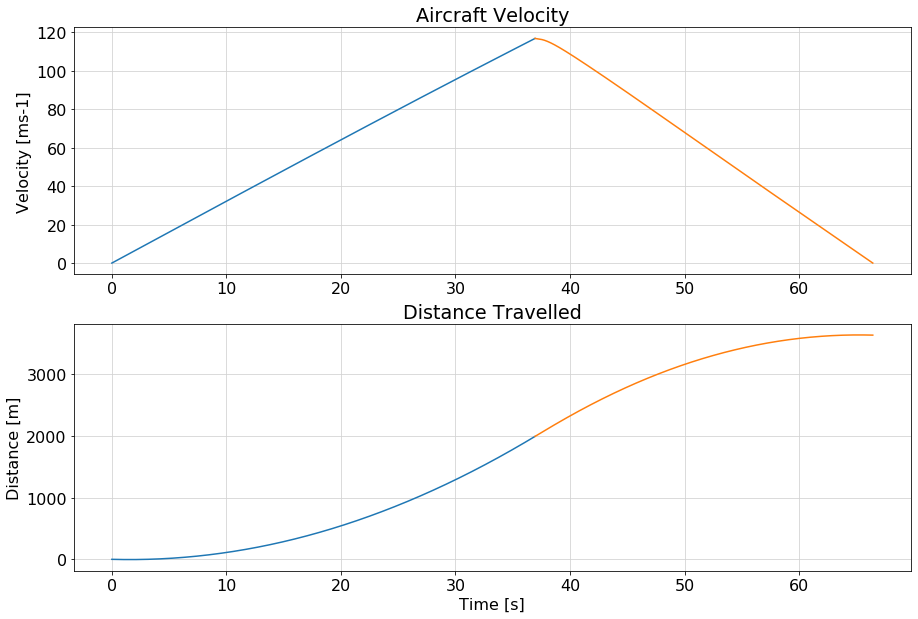

In [249]:
fig, (ax0, ax1) = plt.subplots(2)

ax0.set_title('Aircraft Velocity')
ax0.plot(sol_accel.t,sol_accel.y[0])
ax0.plot(sol_brake.t + sol_accel.t[-1],sol_brake.y[0])
ax0.set_ylabel('Velocity [ms-1]')

ax1.set_title('Distance Travelled')
ax1.plot(sol_accel.t,sol_accel.y[1])
ax1.plot(sol_brake.t + sol_accel.t[-1],sol_brake.y[1])
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Distance [m]')

<hr style="height:1px;border-width:0;color:black;background-color:black">

# V1 OEI Acc-Stop

In [250]:
def SDF_FC(T0,t):
    def model(x,a,n,b,c,d,e,f,x0,x1):
        conds = [x<x0, (x>=x0) & (x<x1),x>=x1]
        funcs = [lambda x:1+a*x**n,lambda x:(b/x) + c*np.exp(-d*x) + e/np.sqrt(x) + f, 0]
        return np.piecewise(x,condlist=conds,funclist=funcs)
    return T0 * model(float(t),-5,3.25,-0.068,1.249,2.419,0.291,-0.108,0.25,5.5)

def SDF_TC(T0,t):
    def model(x,a,b,c,d,e,x0,x1):
        conds = [x<x0, (x>=x0) & (x<x1),x>=x1]
        funcs = [1,lambda x:(a/x) + b*np.exp(-c*x) + d/np.sqrt(x) + e, (a/x1) + b*np.exp(-c*x1) 
                 + d/np.sqrt(x1) + e]
        return np.piecewise(x,condlist=conds,funclist=funcs)
    return T0 * model(float(t),-0.261,1.280,1.345,0.612,-0.073,0.39,12)

 
def toVef(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((T_L + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    dTdt = 0
    
    return np.array([dVxdt,dXdt])

def VefV1(t,y,t_Vef):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((SDF_FC(T_L,t - t_Vef) + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    return np.array([dVxdt,dXdt])


def V1stop(t,y,t_Vef,t_V1):
    Vx = y[0]
    X = y[1]

    dVxdt = (1/m) * ((SDF_FC(T_L,t - t_Vef) + SDF_TC(T_R,t-t_V1)) - D(Vx,0,0) - D_f(Vx,0)) - 0.4*g
#     dVxdt = -(1/m)*(D(Vx,0,0) + D_f(Vx,0)) - 0.25*g
#     dVxdt = - 0.5*g
    dXdt = Vx - Vw
    return np.array([dVxdt,dXdt])

def EngineFail(t,y):
    Vx = y[0]
    return Vx - MS(V_ef)
EngineFail.terminal = True  

def stop(t,y):
    Vx = y[0]
    return Vx
stop.terminal = True

In [251]:
def find_V1_OEI(V1):
    def EngineFail(t,y):
        Vx = y[0]
        return Vx - V_ef
    EngineFail.terminal = True
    def Abort(t,y):
        Vx = y[0]
        return Vx - MS(V1)
    Abort.terminal = True
    
    #starting at V1 and going 2 seconds back to get Vef
    #V1 to Vef (t -ve)
    x0 = 0
    v0 = MS(V1)
    y0 = np.array([v0,x0])
    sol_V1Vef = solve_ivp(lambda t, y: VefV1(t,y,0), [2,0], y0, rtol=1e-9, max_step=1e-3)
    
    V_ef =  sol_V1Vef.y[0][-1]
       
    #Solve given the calculated Vef
    x0 = 0
    v0 = 0
    y0 = np.array([v0,x0])
    sol_Vef = solve_ivp(toVef,[0,60],y0,rtol=1e-9,max_step=1e-3,events=[EngineFail])

    t_V_ef = sol_Vef.t[-1]
      
    x0 = sol_Vef.y[1][-1]
    v0 = sol_Vef.y[0][-1]
    y0 = np.array([v0,x0])
    sol_V1 = solve_ivp(lambda t, y: VefV1(t,y,t_V_ef),[sol_Vef.t[-1],sol_Vef.t[-1]+60],y0,rtol=1e-9,
                       max_step=1e-3, events=[Abort])
    
    t_V1 = sol_V1.t[-1]
      
    x0 = sol_V1.y[1][-1]
    v0 = sol_V1.y[0][-1]
    y0 = np.array([v0,x0])
    sol_brake = solve_ivp(lambda t, y: V1stop(t,y,t_V_ef,t_V1),[sol_V1.t[-1],sol_V1.t[-1]+60],y0,
                          rtol=1e-9,max_step=1e-3,events=[stop])
    
    return sol_brake.y[1][-1] - RunwayLength

In [252]:
%%time
V1 = np.floor(newton(find_V1_OEI,160))

Wall time: 1min 48s


In [253]:
%%time
def EngineFail(t,y):
    Vx = y[0]
    return Vx - V_ef
EngineFail.terminal = True
def Abort(t,y):
    Vx = y[0]
    return Vx - MS(V1)
Abort.terminal = True
    
#starting at V1 and going 2 seconds back to get Vef
#V1 to Vef (t -ve)
x0 = 0
v0 = MS(V1)
y0 = np.array([v0,x0])
sol_V1Vef = solve_ivp(lambda t, y: VefV1(t,y,0), [2,0], y0, rtol=1e-9, max_step=1e-3)
     
V_ef =  sol_V1Vef.y[0][-1]

#Solve given the calculated Vef
x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_Vef = solve_ivp(toVef,[0,60],y0,rtol=1e-9,max_step=1e-3,events=[EngineFail])

t_V_ef = sol_Vef.t[-1]

x0 = sol_Vef.y[1][-1]
v0 = sol_Vef.y[0][-1]
y0 = np.array([v0,x0])
sol_V1 = solve_ivp(lambda t, y: VefV1(t,y,t_V_ef),[sol_Vef.t[-1],sol_Vef.t[-1]+60],y0,rtol=1e-9,
                   max_step=1e-3, events=[Abort])

t_V1 = sol_V1.t[-1]

x0 = sol_V1.y[1][-1]
v0 = sol_V1.y[0][-1]
y0 = np.array([v0,x0])
sol_brake = solve_ivp(lambda t, y: V1stop(t,y,t_V_ef,t_V1),[sol_V1.t[-1],sol_V1.t[-1]+60],y0,
                      rtol=1e-9,max_step=1e-3,events=[stop])

Wall time: 14.6 s


In [254]:
V1, sol_brake.y[1][-1]

(229.0, 3655.5747150907187)

Text(0, 0.5, 'Distance [m]')

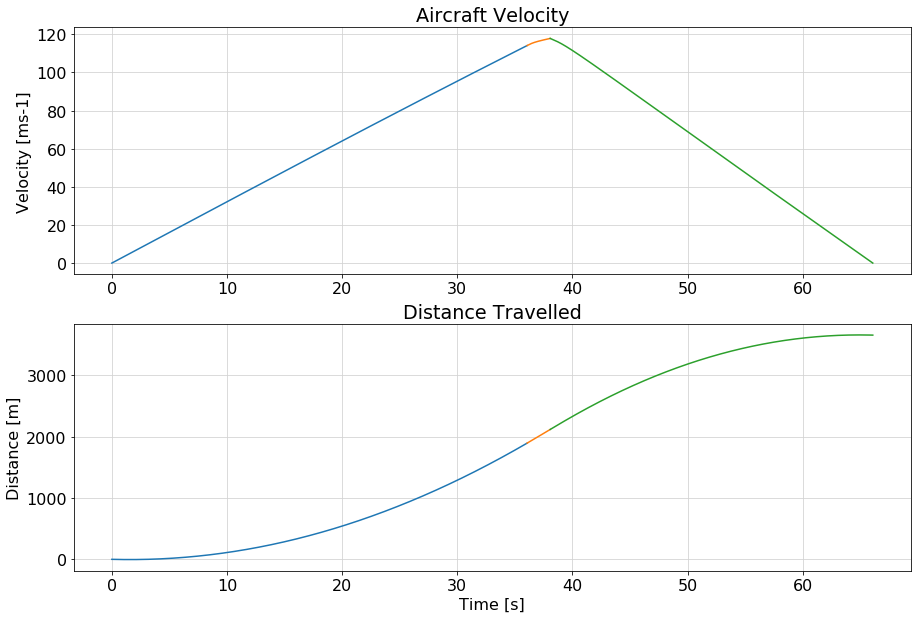

In [255]:
fig, (ax0, ax1) = plt.subplots(2)

ax0.set_title('Aircraft Velocity')
ax0.plot(sol_Vef.t,sol_Vef.y[0])
ax0.plot(sol_V1.t,sol_V1.y[0])
ax0.plot(sol_brake.t,sol_brake.y[0])
ax0.set_ylabel('Velocity [ms-1]')

ax1.plot(sol_Vef.t,sol_Vef.y[1])
ax1.plot(sol_V1.t,sol_V1.y[1])
ax1.plot(sol_brake.t,sol_brake.y[1])
ax1.set_title('Distance Travelled')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Distance [m]')

<hr style="height:1px;border-width:0;color:black;background-color:black">

# Acc-Go

## Calculating Stall Speed

For stall speed, the lift equals the weight of the aircraft. i.e $L=\frac{1}{2}\rho V^{2}C_{L}S=W=mg$
<br> 
Rearranging for V: $V= \sqrt{\frac{2mg}{\rho C_{L}S}}$

In [256]:
CL_max = CL(12)
V_s = np.sqrt((2*m*g)/(rho * S * CL_max))
Knots(V_s)

167.2285474319365

## Calculating V2min

In [257]:
V2 = 1.2 * V_s
Knots(V2), V2

(200.6742569183238, 103.22683775878576)

## Calculate V1

In [258]:
climb_angle = 6
Vmu = np.sqrt((2*m*g)/(rho*S*CL(climb_angle)*np.cos(radian(climb_angle))))
Vlof = 1.05 * Vmu
Vmu, Vlof

(114.10987436541623, 119.81536808368705)

In [259]:
rotate_rate = 3
max_alpha = 6
def rotate_OEI(t,y):
    Vx = y[0]
    X = y[1]
    Alpha = y[2]
    
    dVxdt = (1/m) * ((0 + T_R)*np.cos(np.radians(Alpha)) - D(Vx,0,Alpha) - D_f(Vx,Alpha))
    dXdt = Vx - Vw
    dAlphadt = rotate_rate
        
    return np.array([dVxdt,dXdt,dAlphadt])

def rotation(Vr):
    # initial conditions
    x0  = 0
    vx0 = Vr
    alpha0 = 0

    # combine s and v into array y0
    y0 = np.array([vx0,x0,alpha0])
    print(y0)
    sol_rot = solve_ivp(rotate_OEI,[0,40],y0,rtol=1e-9,max_step = 1e-3,events=[V_LOF])
    return sol_rot.y[2][-1] - climb_angle


def SDF_FC(T0,t):
    def model(x,a,n,b,c,d,e,f,x0,x1):
        conds = [x<x0, (x>=x0) & (x<x1),x>=x1]
        funcs = [lambda x:1+a*x**n,lambda x:(b/x) + c*np.exp(-d*x) + e/np.sqrt(x) + f, 0]
        return np.piecewise(x,condlist=conds,funclist=funcs)
    return T0 * model(float(t),-5,3.25,-0.068,1.249,2.419,0.291,-0.108,0.25,5.5)

def toV1(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((T_L + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt])

def V1Vr(t,y,t_Vef):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((SDF_FC(T_L,t - t_Vef) + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw

    return np.array([dVxdt,dXdt])  

def rotate(t,y,t_Vef):
    Vx = y[0]
    X = y[1]
    Alpha = y[2]
    
    dVxdt = (1/m) * ((SDF_FC(T_L,t_Vef) + T_R)*np.cos(np.radians(Alpha)) - D(Vx,0,Alpha) - D_f(Vx,Alpha))
    dXdt = Vx - Vw
    
    if Alpha < max_alpha:
        dAlphadt = rotate_rate
    else:
        dAlphadt = 0
    
    return np.array([dVxdt,dXdt,dAlphadt])

def climb(t,y):
    Vx = y[0]  
    Vz = y[1]
    X = y[2]
    H = y[3]
    
    V = np.sqrt(Vx**2 + Vz**2)

    dVxdt = (1/m) * ((0 + T_R)*np.cos(np.radians(theta)) - D(V,0,theta)*np.cos(np.radians(theta)) 
                     - Lift(V,theta)*np.sin(np.radians(theta)))
    dVzdt = (1/m) * ((0 + T_R)*np.sin(np.radians(theta)) + Lift(V,theta)*np.cos(np.radians(theta)) 
                     - m*g - D(V,0,theta)*np.sin(np.radians(theta)))
    dXdt = Vx - Vw
    dHdt = Vz
    
    return np.array([dVxdt, dVzdt, dXdt, dHdt])

#Constraints
#  Vr
def set_Vr(t,y):
    Vx = y[0]
    return Vx - (Vr)
set_Vr.terminal = True

#Vlof
def V_LOF(t,y):
    return y[0] - Vlof
V_LOF.terminal = True

# Screen Height
def ScreenHeight(t,y):
    return y[3] - 10.7
ScreenHeight.terminal = True

In [260]:
Vr = newton(rotation,Vlof-10)

def GoV1(V1):
    def set_V1(t,y):
        Vx = y[0]
        return Vx - MS(V1)
    set_V1.terminal = True

    print(V1)    
        
    x0 = 0
    v0 = 0
    y0 = np.array([v0,x0])

    sol_groundrunV1 = solve_ivp(toV1,[0,60],y0,rtol=1e-9,max_step=1e-3,events=[set_V1])

    t_V1 = sol_groundrunV1.t[-1]

    x0 = sol_groundrunV1.y[1][-1]
    v0 = sol_groundrunV1.y[0][-1]
    y0 = np.array([v0,x0])
    sol_groundrunVr = solve_ivp(lambda t, y: V1Vr(t,y,t_V1),[t_V1,t_V1+60],y0,rtol=1e-9,max_step=1e-3
                                ,events=[set_Vr])


    x0  = sol_groundrunVr.y[1][-1] # initial s
    vx0 = sol_groundrunVr.y[0][-1] # initial v
    alpha0 = 0
    y0 = np.array([vx0,x0,alpha0])
    sol_rotate = solve_ivp(lambda t, y: rotate(t,y,t_V1),[0,40],y0,rtol=1e-9,max_step = 1e-3,events=[V_LOF])

    global theta
    theta = sol_rotate.y[2][-1]
    
    x0 = sol_rotate.y[1][-1]
    vz0 = 0
    h0 = 0
    vx0 = sol_rotate.y[0][-1]
    y0 = np.array([vx0,vz0,x0,h0])

    sol_LOF = solve_ivp(climb,[0,40],y0,rtol=1e-9,max_step = 1e-3,events=[ScreenHeight])
    
    return sol_LOF.y[2][-1] - RunwayLength

[109.81536808   0.           0.        ]
[109.82644962   0.           0.        ]


In [261]:
V1 = np.ceil(newton(GoV1,160))

160.0
160.0161
185.98448548653994
183.56365901723086
183.75739170418484
183.75891290177654
183.75891185831335


In [262]:
def set_V1(t,y):
    Vx = y[0]
    return Vx - MS(V1)
set_V1.terminal = True

x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_groundrunV1 = solve_ivp(toV1,[0,60],y0,rtol=1e-9,max_step=1e-3,events=[set_V1])

t_V1 = sol_groundrunV1.t[-1]

x0 = sol_groundrunV1.y[1][-1]
v0 = sol_groundrunV1.y[0][-1]
y0 = np.array([v0,x0])
sol_groundrunVr = solve_ivp(lambda t, y: V1Vr(t,y,t_V1),[t_V1,t_V1+60],y0,rtol=1e-9,max_step=1e-3,
                            events=[set_Vr])

x0  = sol_groundrunVr.y[1][-1] # initial s
vx0 = sol_groundrunVr.y[0][-1] # initial v
alpha0 = 0
y0 = np.array([vx0,x0,alpha0])
sol_rotate = solve_ivp(lambda t, y: rotate(t,y,t_V1),[0,40],y0,rtol=1e-9,max_step = 1e-3,events=[V_LOF])

theta = sol_rotate.y[2][-1]
x0 = sol_rotate.y[1][-1]
vz0 = 0
h0 = 0
vx0 = sol_rotate.y[0][-1]
y0 = np.array([vx0,vz0,x0,h0])
sol_LOF = solve_ivp(climb,[0,40],y0,rtol=1e-9,max_step = 1e-3,events=[ScreenHeight])

## Graph

### Ground Run

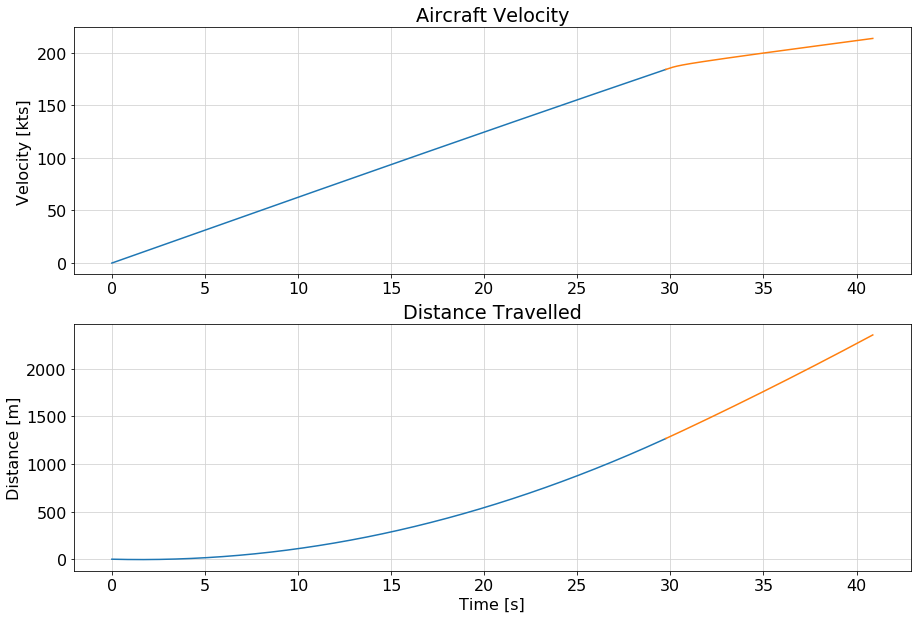

In [263]:
fig, (ax0, ax1) = plt.subplots(2)

ax0.set_title('Aircraft Velocity')
ax0.set_ylabel('Velocity [kts]')
ax0.plot(sol_groundrunV1.t,Knots(sol_groundrunV1.y[0]))
ax0.plot(sol_groundrunVr.t,Knots(sol_groundrunVr.y[0]))

ax1.set_title('Distance Travelled')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Distance [m]')
ax1.plot(sol_groundrunV1.t,sol_groundrunV1.y[1])
ax1.plot(sol_groundrunVr.t,sol_groundrunVr.y[1])

In [264]:
sol_groundrunVr.y[1][-1], sol_groundrunVr.y[0][-1]

(2356.7685875548, 109.82090885209124)

### Transition / Rotate

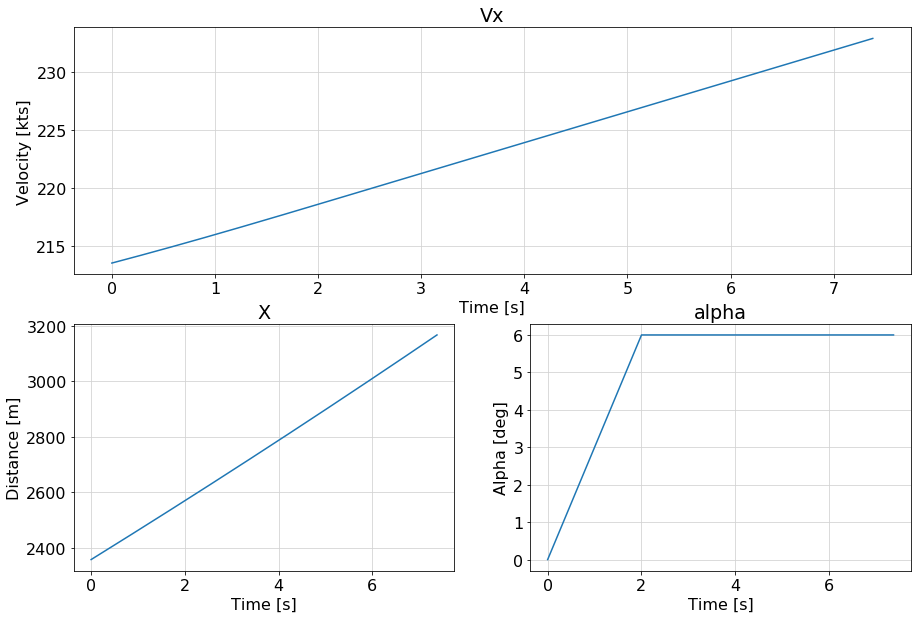

In [265]:
ax0 = plt.subplot(211)
ax1 = plt.subplot(223)
ax2 = plt.subplot(224)

ax0.set_title('Vx')
ax0.set_ylabel('Velocity [kts]')
ax0.set_xlabel('Time [s]')
ax0.plot(sol_rotate.t,Knots(sol_rotate.y[0]))
ax1.set_title('X')
ax1.set_ylabel('Distance [m]')
ax1.set_xlabel('Time [s]')
ax1.plot(sol_rotate.t,sol_rotate.y[1])
ax2.set_title('alpha')
ax2.set_ylabel('Alpha [deg]')
ax2.set_xlabel('Time [s]')
ax2.plot(sol_rotate.t,sol_rotate.y[2])

### Climb Out to 35ft

In [266]:
V1, sol_LOF.y[2][-1]

(184.0, 3654.499148744401)

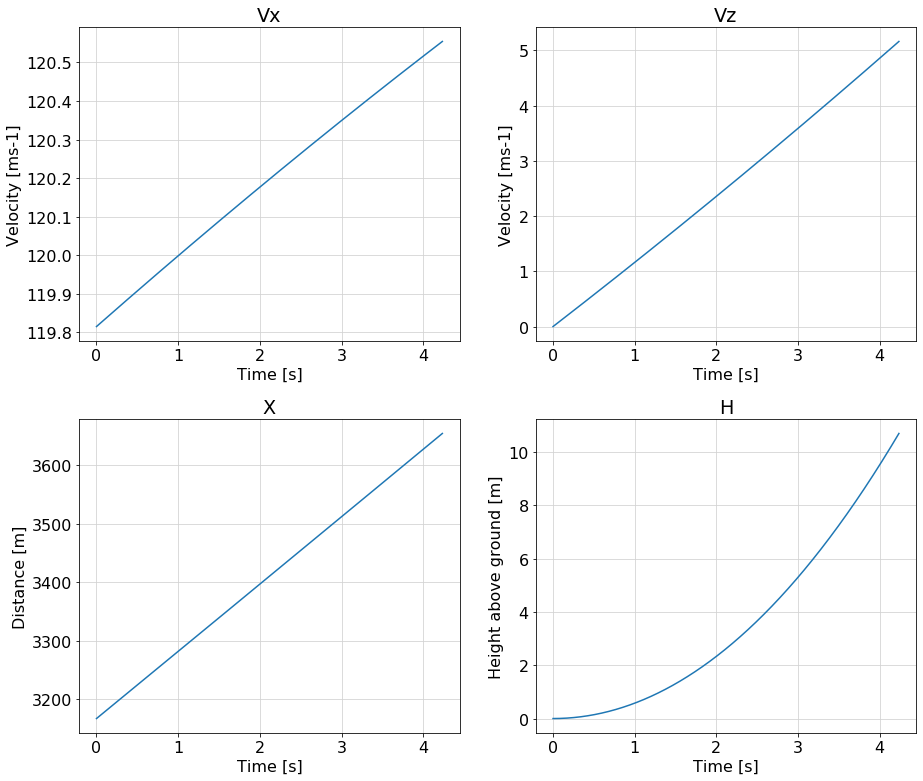

In [267]:
fig, ax = plt.subplots(2,2)

ax[0,0].set_title('Vx')
ax[0,0].set_ylabel('Velocity [ms-1]')
ax[0,0].plot(sol_LOF.t,sol_LOF.y[0])
ax[0,1].set_title('Vz')
ax[0,1].set_ylabel('Velocity [ms-1]')
ax[0,1].plot(sol_LOF.t,sol_LOF.y[1])
ax[1,0].set_title('X')
ax[1,0].set_ylabel('Distance [m]')
ax[1,0].plot(sol_LOF.t,sol_LOF.y[2])
ax[1,1].set_title('H')
ax[1,1].set_ylabel('Height above ground [m]')
ax[1,1].plot(sol_LOF.t,sol_LOF.y[3])

ax[0,0].set_xlabel('Time [s]')
ax[0,1].set_xlabel('Time [s]')
ax[1,0].set_xlabel('Time [s]')
ax[1,1].set_xlabel('Time [s]')

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.25, wspace=0.2)

In [268]:
sol_LOF.y[0][-1] > V2

True